In [1]:
!pip install wordcloud
!pip install colour

In [2]:
## Installing font for Hindi for matplotlib ##
!apt-get install -y fonts-lohit-deva
!fc-list :lang=hi family

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-lohit-deva
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 78.9 kB of archives.
After this operation, 198 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-lohit-deva all 2.95.4-4 [78.9 kB]
Fetched 78.9 kB in 1s (75.2 kB/s)
Selecting previously unselected package fonts-lohit-deva.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-lohit-deva_2.95.4-4_all.deb ...
Unpacking fonts-lohit-deva (2.95.4-4) ...
Setting up fonts-lohit-deva (2.95.4-4) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Lohit Devanagari


In [11]:
import os
import random
import time
import wandb
import re, string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from colour import Color
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data

In [9]:
## Download the dataset ##
import requests
import tarfile

def download_data(save_path):

    data_url = r"https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

    r = requests.get(data_url, allow_redirects=True)
    tar_path = "data_assignment3.tar"

    if r.status_code == 200:
        with open(tar_path, 'wb') as f:
            f.write(r.content)

    tar_file = tarfile.open(tar_path)
    tar_file.extractall(save_path)
    tar_file.close()


# downloading and extracting the data to drive

download_data("/content/drive/MyDrive/DakshinaDataset")

# Data Preprocessing

In [10]:
# Files with English to Devanagari (Hindi) translation word by word
# Punctutations have already been cleaned from this file

def get_data_files(language):
    """ Function fo read data
    """

    ## REPLACE THIS PATH UPTO dakshina_dataset_v1.0 with your own dataset path ##
    template = "/content/drive/MyDrive/DakshinaDataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.{}.tsv"

    train_tsv = template.format("train")
    val_tsv = template.format("dev")
    test_tsv = template.format("test")

    return train_tsv, val_tsv, test_tsv

## Utility functions for preprocessing data ##

def add_start_end_tokens(df, cols, sos="\t", eos="\n"):
    """ Adds EOS and SOS tokens to data
    """
    def add_tokens(s):
        # \t = starting token
        # \n = ending token
        return sos + str(s) + eos

    for col in cols:
        df[col] = df[col].apply(add_tokens)

def tokenize(lang, tokenizer=None):
    """ Uses tf.keras tokenizer to tokenize the data/words into characters
    """

    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    else:
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    return lang_tensor, tokenizer

def preprocess_data(fpath, input_lang_tokenizer=None, targ_lang_tokenizer=None):
    """ Reads, tokenizes and adds SOS/EOS tokens to data based on above functions
    """

    df = pd.read_csv(fpath, sep="\t", header=None)

    # adding start and end tokens to know when to stop predicting
    add_start_end_tokens(df, [0,1])

    input_lang_tensor, input_tokenizer = tokenize(df[1].astype(str).tolist(),
                                                    tokenizer=input_lang_tokenizer)

    targ_lang_tensor, targ_tokenizer = tokenize(df[0].astype(str).tolist(),
                                                    tokenizer=targ_lang_tokenizer)

    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))

    return dataset, input_tokenizer, targ_tokenizer

# Model Building

In [11]:
## Utility functions ##
def get_layer(name, units, dropout, return_state=False, return_sequences=False):

    if name=="rnn":
        return layers.SimpleRNN(units=units, dropout=dropout,
                                return_state=return_state,
                                return_sequences=return_sequences)

    if name=="gru":
        return layers.GRU(units=units, dropout=dropout,
                          return_state=return_state,
                          return_sequences=return_sequences)

    if name=="lstm":
        return layers.LSTM(units=units, dropout=dropout,
                           return_state=return_state,
                           return_sequences=return_sequences)

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, enc_state, enc_out):

    enc_state = tf.concat(enc_state, 1)
    enc_state = tf.expand_dims(enc_state, 1)

    score = self.V(tf.nn.tanh(self.W1(enc_state) + self.W2(enc_out)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * enc_out
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


class Encoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, encoder_vocab_size, embedding_dim, dropout):
        super(Encoder, self).__init__()
        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.embedding = tf.keras.layers.Embedding(encoder_vocab_size, embedding_dim)
        self.create_rnn_layers()

    def call(self, x, hidden):
        x = self.embedding(x)
        outputs=x
        # x = self.rnn_layers[0](x, initial_state=hidden)

        # for layer in self.rnn_layers[1:]:
        #     x = layer(x)

        # output, state = x[0], x[1:]
        # print("LSTM layer:", self.layer_type)
        # output = self.rnn_layers[0](outputs, initial_state=hidden)
        # print("Returned:", type(output), output)

        if (self.layer_type=='lstm'):
            outputs, h, c = self.rnn_layers[0](outputs, initial_state=hidden)
            state = [h, c]
        else:
            outputs, h = self.rnn_layers[0](outputs, initial_state=hidden)
            state = [h]

        # Remaining LSTM layers just take outputs from previous layer
        for layer in self.rnn_layers[1:]:
            if (self.layer_type=='lstm'):
               outputs, h, c = layer(outputs)
               state = [h, c]  # update state if needed
            else:
               outputs, h = layer(outputs)
               state = [h]

        return outputs, state

    def create_rnn_layers(self):
        self.rnn_layers = []

        for i in range(self.n_layers):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))


    def initialize_hidden_state(self, batch_size):

        if self.layer_type != "lstm":
            return [tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units))]*2

class Decoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, decoder_vocab_size, embedding_dim, dropout, attention=False):
        super(Decoder, self).__init__()

        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.embedding_layer = layers.Embedding(input_dim=decoder_vocab_size,
                                                output_dim=embedding_dim)

        self.dense = layers.Dense(decoder_vocab_size, activation="softmax")
        self.flatten = layers.Flatten()
        if self.attention:
            self.attention_layer = BahdanauAttention(self.units)
        self.create_rnn_layers()

    def call(self, x, hidden, enc_out=None):

        # x = self.embedding_layer(x)

        # if self.attention:
        #     context_vector, attention_weights = self.attention_layer(hidden, enc_out)
        #     x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        # else:
        #     attention_weights = None

        # x = self.rnn_layers[0](x, initial_state=hidden)

        # for layer in self.rnn_layers[1:]:
        #     x = layer(x)

        # output, state = x[0], x[1:]

        # output = self.dense(self.flatten(output))

        x = self.embedding_layer(x)

        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None

        # First LSTM layer gets the initial hidden state
        if (self.layer_type=='lstm'):
            x, h, c = self.rnn_layers[0](x, initial_state=hidden)
            state = [h, c]
        else:
            x, h = self.rnn_layers[0](x, initial_state=hidden)
            state = [h]

        # Subsequent layers use only the output of the previous layer
        for layer in self.rnn_layers[1:]:
            if (self.layer_type=='lstm'):
                x, h, c = layer(x)
                state = [h, c]  # Update state if you want final output from last LSTM
            else:
                x, h = layer(x)
                state = [h]

        output = self.dense(self.flatten(x))

        return output, state, attention_weights

    def create_rnn_layers(self):
        self.rnn_layers = []

        for i in range(self.n_layers - 1):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))

        self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                            return_sequences=False,
                                            return_state=True))

In [12]:
class BeamSearch():
    def __init__(self, model, k):
        self.k = k
        self.model = model
        self.acc = tf.keras.metrics.Accuracy()

    def sample_beam_search(self, probs):

        m, n = probs.shape
        output_sequences = [[[], 0.0]]

        for row in probs:
            beams = []

            for tup in output_sequences:
                seq, score = tup
                for j in range(n):
                    new_beam = [seq + [j], score - tf.math.log(row[j])]
                    beams.append(new_beam)

            output_sequences = sorted(beams, key=lambda x: x[1])[:self.k]

        tensors, scores = list(zip(*output_sequences))
        tensors = list(map(lambda x: tf.expand_dims(tf.constant(x),0), tensors))

        return tf.concat(tensors, 0), scores

    def beam_accuracy(self, input, target):
        accs = []

        for i in range(self.k):
            self.acc.reset_states()
            self.acc.update_state(target, input[i, :])
            accs.append(self.acc.result())

        return max(accs)

    def step(self, input, target, enc_state):

        batch_acc = 0
        sequences = []

        enc_out, enc_state = self.model.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*self.model.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        for i in range(target.shape[0]):

            possibilities, scores = self.sample_beam_search(sequences[i, :, :])
            batch_acc += self.beam_accuracy(possibilities, target[i, 1:])

        batch_acc = batch_acc / target.shape[0]

        return 0, batch_acc

    def evaluate(self, test_dataset, batch_size=None, upto=5, use_wandb=False):

        if batch_size is not None:
            self.model.batch_size = batch_size
            test_dataset = test_dataset.batch(batch_size)
        else:
            self.model.batch_size = 1

        test_acc = 0
        enc_state = self.model.encoder.initialize_hidden_state(self.model.batch_size)

        for batch, (input, target) in enumerate(test_dataset.take(upto)):

           _, acc = self.step(input, target, enc_state)
           test_acc += acc

        if use_wandb:
            wandb.log({"test acc (beam search)": test_acc / upto})

        print(f"Test Accuracy on {upto*batch_size} samples: {test_acc / upto:.4f}\n")

    def translate(self, word):

        word = "\t" + word + "\n"
        sequences = []
        result = []

        inputs = self.model.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.model.max_input_len,
                                                               padding="post")


        enc_state = self.model.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.model.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.model.max_target_len):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        possibilities, scores = self.sample_beam_search(tf.squeeze(sequences, 0))
        output_words = self.model.targ_tokenizer.sequences_to_texts(possibilities.numpy())

        def post_process(word):
            word = word.split(" ")[:-1]
            return "".join([x for x in word])

        output_words = list(map(post_process, output_words))

        return output_words, scores

In [13]:
class Seq2SeqModel():
    def __init__(self, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention=False):
        self.embedding_dim = embedding_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.layer_type = layer_type
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.stats = []
        self.batch_size = 128
        self.use_beam_search = False

    def build(self, loss, optimizer, metric):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def set_vocabulary(self, input_tokenizer, targ_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.create_model()

    def create_model(self):

        encoder_vocab_size = len(self.input_tokenizer.word_index) + 1
        decoder_vocab_size = len(self.targ_tokenizer.word_index) + 1

        self.encoder = Encoder(self.layer_type, self.encoder_layers, self.units, encoder_vocab_size,
                               self.embedding_dim, self.dropout)

        self.decoder = Decoder(self.layer_type, self.decoder_layers, self.units, decoder_vocab_size,
                               self.embedding_dim,  self.dropout, self.attention)

    @tf.function
    def train_step(self, input, target, enc_state):

        loss = 0

        with tf.GradientTape() as tape:

            enc_out, enc_state = self.encoder(input, enc_state)

            dec_state = enc_state
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

            ## We use Teacher forcing to train the network
            ## Each target at timestep t is passed as input for timestep t + 1

            if random.random() < self.teacher_forcing_ratio:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    dec_input = tf.expand_dims(target[:,t], 1)

            else:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)


            batch_loss = loss / target.shape[1]

            variables = self.encoder.variables + self.decoder.variables
            gradients = tape.gradient(loss, variables)

            self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, self.metric.result()

    @tf.function
    def validation_step(self, input, target, enc_state):

        loss = 0

        enc_out, enc_state = self.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
            loss += self.loss(target[:,t], preds)
            self.metric.update_state(target[:,t], preds)

            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        batch_loss = loss / target.shape[1]

        return batch_loss, self.metric.result()


    def fit(self, dataset, val_dataset, batch_size=128, epochs=10, use_wandb=False, teacher_forcing_ratio=1.0):

        self.batch_size = batch_size
        self.teacher_forcing_ratio = teacher_forcing_ratio

        steps_per_epoch = len(dataset) // self.batch_size
        steps_per_epoch_val = len(val_dataset) // self.batch_size

        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        val_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)

        # useful when we need to translate the sentence
        sample_inp, sample_targ = next(iter(dataset))
        self.max_target_len = sample_targ.shape[1]
        self.max_input_len = sample_inp.shape[1]

        template = "\nTrain Loss: {0:.4f} Train Accuracy: {1:.4f} Validation Loss: {2:.4f} Validation Accuracy: {3:.4f}"

        print("-"*100)
        for epoch in range(1, epochs+1):
            print(f"EPOCH {epoch}\n")

            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_state()

            starting_time = time.time()
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("Training ...\n")
            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                batch_loss, acc = self.train_step(input, target, enc_state)
                total_loss += batch_loss
                total_acc += acc


                if batch==0 or ((batch + 1) % 100 == 0):
                    print(f"Batch {batch+1} Loss {batch_loss:.4f}")

            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch

            # Validation loop ##
            total_val_loss = 0
            total_val_acc = 0
            self.metric.reset_state()

            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("\nValidating ...")
            for batch, (input, target) in enumerate(val_dataset.take(steps_per_epoch_val)):
                batch_loss, acc = self.validation_step(input, target, enc_state)
                total_val_loss += batch_loss
                total_val_acc += acc

            avg_val_acc = total_val_acc / steps_per_epoch_val
            avg_val_loss = total_val_loss / steps_per_epoch_val

            print(template.format(avg_loss, avg_acc*100, avg_val_loss, avg_val_acc*100))

            time_taken = time.time() - starting_time
            self.stats.append({"epoch": epoch,
                            "train loss": avg_loss,
                            "val loss": avg_val_loss,
                            "train acc": avg_acc*100,
                            "val acc": avg_val_acc*100,
                            "training time": time_taken})

            if use_wandb:
                wandb.log(self.stats[-1])

            print(f"\nTime taken for the epoch {time_taken:.4f}")
            print("-"*100)

        print("\nModel trained successfully !!")

    def evaluate(self, test_dataset, batch_size=None):

        if batch_size is not None:
            self.batch_size = batch_size

        steps_per_epoch_test = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        self.metric.reset_state()

        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        print("\nRunning test dataset through the model...\n")
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):
            batch_loss, acc = self.validation_step(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_acc += acc

        avg_test_acc = total_test_acc / steps_per_epoch_test
        avg_test_loss = total_test_loss / steps_per_epoch_test

        print(f"Test Loss: {avg_test_loss:.4f} Test Accuracy: {avg_test_acc:.4f}")

        return avg_test_loss, avg_test_acc


    def translate(self, word, get_heatmap=False):

        word = "\t" + word + "\n"

        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.max_input_len,
                                                               padding="post")

        result = ""
        att_wts = []

        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.max_target_len):

            preds, dec_state, attention_weights = self.decoder(dec_input, dec_state, enc_out)

            if get_heatmap:
                att_wts.append(attention_weights)

            preds = tf.argmax(preds, 1)
            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], att_wts[:-1]

        return result[:-1], att_wts[:-1]

    def plot_attention_heatmap(self, word, ax, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

        translated_word, attn_wts = self.translate(word, get_heatmap=True)
        attn_heatmap = tf.squeeze(tf.concat(attn_wts, 0), -1).numpy()

        input_word_len = len(word)
        output_word_len = len(translated_word)

        ax.imshow(attn_heatmap[:, :input_word_len])

        font_prop = FontProperties(fname=font_path, size=18)

        ax.set_xticks(np.arange(input_word_len))
        ax.set_yticks(np.arange(output_word_len))

        ax.set_xticklabels(list(word))
        ax.set_yticklabels(list(translated_word), fontproperties=font_prop)


# Visualizing Model Outputs

In [14]:
def get_colors(inputs, targets, preds):

    n = len(targets)
    smoother = SmoothingFunction().method2
    def get_scores(target, output, smoother):
        return sentence_bleu(list(list(target)), list(output), smoothing_function=smoother)

    red = Color("red")
    colors = list(red.range_to(Color("violet"),n))
    colors = list(map(lambda c: c.hex, colors))

    scores = []
    for i in range(n):
        scores.append(get_scores(targets[i], preds[i], smoother))

    d = dict(zip(sorted(scores), list(range(n))))
    ordered_colors = list(map(lambda x: colors[d[x]], scores))

    input_colors = dict(zip(inputs, ordered_colors))
    target_colors = dict(zip(targets, ordered_colors))
    pred_colors = dict(zip(preds, ordered_colors))

    return input_colors, target_colors, pred_colors


class Colorizer():
    def __init__(self, word_to_color, default_color):

        self.word_to_color = word_to_color
        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

def randomly_evaluate(model, test_file=get_data_files("hi")[2], n=10):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    print(f"Randomly evaluating the model on {n} words\n")

    for i in range(n):
        word = str(df[1][i])

        print(f"Input word: {word}")
        print(f"Actual translation: {str(df[0][i])}")
        print(f"Model translation: {model.translate(word)[0]}\n")

def visualize_model_outputs(model, test_file=get_data_files("hi")[2], n=10, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    inputs = df[1].astype(str).tolist()
    targets = df[0].astype(str).tolist()
    preds = list(map(lambda word: model.translate(word)[0], inputs))

    # Generate colors for the words
    input_colors, target_colors, pred_colors =  get_colors(inputs, targets, preds)
    color_fn_ip = Colorizer(input_colors, "white")
    color_fn_tr = Colorizer(target_colors, "white")
    color_fn_op = Colorizer(pred_colors, "white")

    input_text = Counter(inputs)
    target_text = Counter(targets)
    output_text = Counter(preds)

    fig, axs = plt.subplots(1,3, figsize=(30, 15))
    plt.tight_layout()

    wc_in = WordCloud(random_state=1).generate_from_frequencies(input_text)
    wc_out = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(output_text)
    wc_tar = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(target_text)

    axs[0].set_title("Input words", fontsize=30)
    axs[0].imshow(wc_in.recolor(color_func=color_fn_ip))
    axs[1].set_title("Target words", fontsize=30)
    axs[1].imshow(wc_tar.recolor(color_func=color_fn_tr))
    axs[2].set_title("Model outputs", fontsize=30)
    axs[2].imshow(wc_out.recolor(color_func=color_fn_op))
    plt.show()



def test_on_dataset(language, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention, teacher_forcing_ratio=1.0, save_outputs=None):

    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    model = Seq2SeqModel(embedding_dim,
                         encoder_layers,
                         decoder_layers,
                         layer_type,
                         units,
                         dropout,
                         attention)

    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())

    model.fit(dataset, val_dataset, epochs=10, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)

    ## Character level accuracy ##
    test_dataset, _, _ = preprocess_data(TEST_TSV, model.input_tokenizer, model.targ_tokenizer)
    test_loss, test_acc = model.evaluate(test_dataset, batch_size=100)

    ##  Word level accuracy ##
    test_tsv = pd.read_csv(TEST_TSV, sep="\t", header=None)
    inputs = test_tsv[1].astype(str).tolist()
    targets = test_tsv[0].astype(str).tolist()

    outputs = []

    for word in inputs:
        outputs.append(model.translate(word)[0])

    def word_level_acc(outputs, targets):
        return np.sum(np.asarray(outputs) == np.array(targets)) / len(outputs)

    print(f"Word level accuracy: {word_level_acc(outputs, targets)}")

    if save_outputs is not None:
        df = pd.DataFrame()
        df["inputs"] = inputs
        df["targets"] = targets
        df["outputs"] = outputs
        df.to_csv(save_outputs)


    return model

#randomly_evaluate(model, n=15)

# Visualizing Model Connectivity (Q6)

In [15]:
# Tools for getting model connectivity between input and output characters
def get_lstm_output_a(decoder, x, hidden, enc_out=None):

    x = decoder.embedding_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    x = decoder.rnn_layers[0](x, initial_state=hidden)

    for layer in decoder.rnn_layers[1:]:
        x = layer(x)

    output, state = x[0], x[1:]

    #output = decoder.dense(decoder.flatten(output))

    return output, state, attention_weights

def get_lstm_output(decoder, x, hidden, enc_out=None):
    x = decoder.embedding_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    # First layer with initial state
    x, h, c = decoder.rnn_layers[0](x, initial_state=hidden)
    state = [h, c]

    # Remaining layers
    for layer in decoder.rnn_layers[1:]:
        x, h, c = layer(x)
        state = [h, c]  # keep the last layer's state

    return x, state, attention_weights

def get_output_from_embedding(encoder, x, hidden):
    print("Calling LSTM with:", type(x), x.shape)
    print("Hidden is:", type(hidden), [h.shape for h in hidden])
    # x = encoder.rnn_layers[0](x, initial_state=hidden)

    # for layer in encoder.rnn_layers[1:]:
    #     x = layer(x)

    # output, state = x[0], x[1:]

    # return output, state

    # Unpack the first layer's outputs properly
    x, h, c = encoder.rnn_layers[0](x, initial_state=hidden)
    state = [h, c]

    # Only pass the actual output to the next layers
    for layer in encoder.rnn_layers[1:]:
        x, h, c = layer(x)
        state = [h, c]

    return x, state


def get_connectivity(model, word):

    word = "\t" + word + "\n"

    inputs = model.input_tokenizer.texts_to_sequences([word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=model.max_input_len,
                                                            padding="post")

    result = ""

    gradient_list = []

    enc_state = model.encoder.initialize_hidden_state(1)
    embedded_in = model.encoder.embedding(inputs)


    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        tape.watch(embedded_in)

        enc_out, enc_state = get_output_from_embedding(model.encoder, embedded_in, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, model.max_target_len):

            lstm_out, dec_state, _ = get_lstm_output(model.decoder, dec_input, dec_state, enc_out)

            preds = model.decoder.dense(model.decoder.flatten(lstm_out))
            gradient_list.append(tape.gradient(lstm_out, embedded_in)[0])

            preds = tf.argmax(preds, 1)
            next_char = model.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], gradient_list[:-1]

        return result[:-1], gradient_list[:-1]


In [16]:
# Imports for visualising the model connectivity
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
# from keras.utils import np_utils

from IPython.display import HTML as html_print
from IPython.display import display
import tensorflow.keras.backend as K

# get html element
def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int(value * 19)
    if value == 19:
        value -= 1
    return colors[value]

# sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z

def softmax(x):
    v = np.exp(x)
    v = v / np.sum(v)
    return v

def get_gradient_norms(grad_list, word, activation="sigmoid"):
    grad_norms = []
    for grad_tensor in grad_list:
        grad_mags = tf.norm(grad_tensor, axis=1)
        grad_mags = grad_mags[:len(word)]
        if activation == "softmax":
            grad_mags_scaled = softmax(grad_mags)
        elif activation == "scaler":
            scaler = MinMaxScaler()
            grad_mags = tf.reshape(grad_mags, (-1,1))
            grad_mags_scaled = scaler.fit_transform(grad_mags)
        else:
            grad_mags_scaled = sigmoid(grad_mags)
        grad_norms.append(grad_mags_scaled)
    return grad_norms

def visualize(grad_norms, word, translated_word):
    print("Original Word:", word)
    print("Transliterated Word:", translated_word)
    for i in range(len(translated_word)):
        print("Connectivity Visualization for", translated_word[i],":")
        text_colours = []
        for j in range(len(grad_norms[i])):
            text = (word[j], get_clr(grad_norms[i][j]))
            text_colours.append(text)
        print_color(text_colours)

def visualise_connectivity(model, word, activation="sigmoid"):
    translated_word, grad_list = get_connectivity(model, word)
    grad_norms = get_gradient_norms(grad_list, word, activation)
    visualize(grad_norms, word, translated_word)

In [17]:
model = test_on_dataset(language="hi",
                        embedding_dim=256,
                        encoder_layers=3,
                        decoder_layers=3,
                        layer_type="lstm",
                        units=256,
                        dropout=0.2,
                        attention=True,
                        save_outputs= "Eng_to_Hin_With_att.csv")

----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9901
Batch 100 Loss 1.1834
Batch 200 Loss 1.0549
Batch 300 Loss 0.9827

Validating ...

Train Loss: 1.2051 Train Accuracy: 65.4173 Validation Loss: 2.6436 Validation Accuracy: 57.0710

Time taken for the epoch 83.1516
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0017
Batch 100 Loss 1.0326
Batch 200 Loss 0.9730
Batch 300 Loss 0.9877

Validating ...

Train Loss: 0.9830 Train Accuracy: 71.6718 Validation Loss: 2.6014 Validation Accuracy: 55.7715

Time taken for the epoch 32.6782
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9283
Batch 100 Loss 0.9448
Batch 200 Loss 0.9228
Batch 300 Loss 0.8997

Validating ...

Train Loss: 0.9483 Train Accuracy: 72.7000 Validation Loss: 2.5028 Validation Accuracy: 52.3507

Time taken for the epoch 35.5840
-----------------------------------------------------

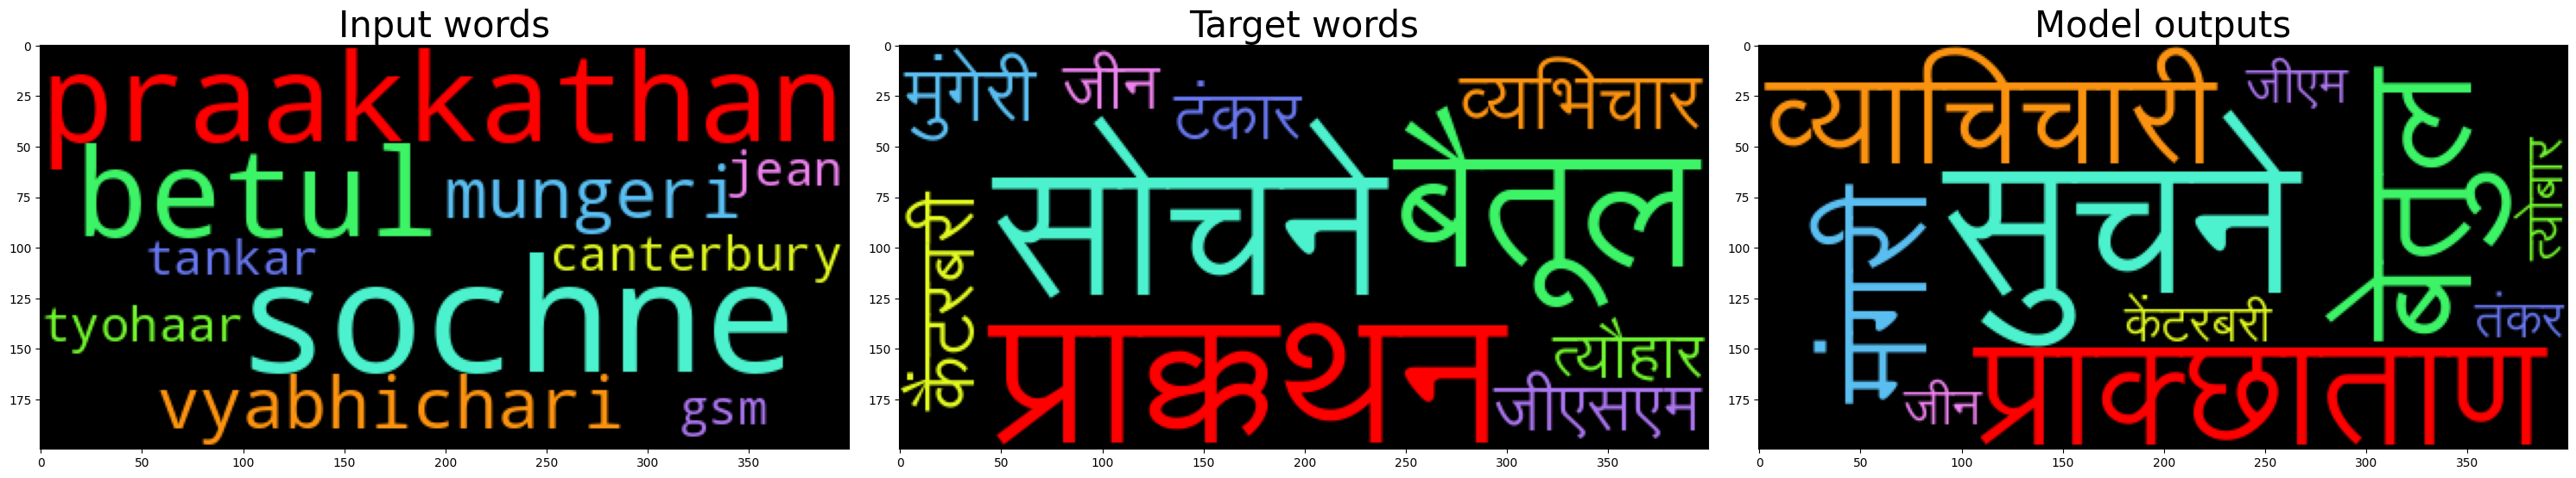

In [18]:
visualize_model_outputs(model, n=10)

In [19]:
def get_test_words(n):
    test_df = pd.read_csv(get_data_files("hi")[2])
    test_sample = test_df.sample(n)
    test_sample.reset_index(inplace=True, drop=True)
    test_words = []
    for i in test_sample.index:
        entry = test_sample["अंक\tank\t5"].loc[i]
        parts = entry.split("\t")
        word = parts[1]
        test_words.append(word)
    return test_words

test_words = get_test_words(5)
print(test_words)

['abvp', 'larry', 'shrimati', 'avegyanik', 'praudh']


NameError: name 'model' is not defined

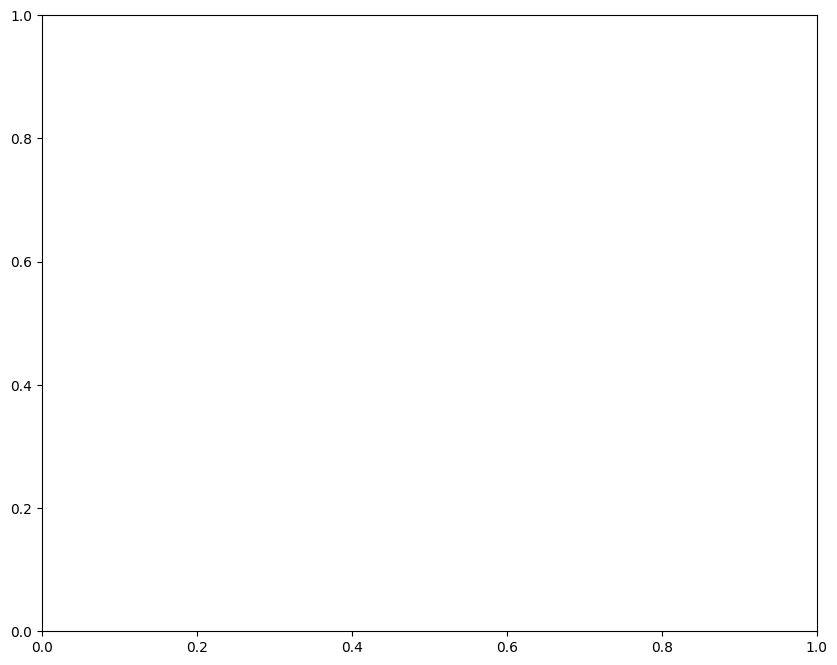

In [12]:
fig, ax= plt.subplots(figsize=(10,8))
model.plot_attention_heatmap('larry', ax)

In [20]:
for word in test_words:
    visualise_connectivity(model, word, activation="scaler")

Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: abvp
Transliterated Word: एब्वप
Connectivity Visualization for ए :


<ipython-input-16-a3beb7fceb7f>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for ब :


Connectivity Visualization for ् :


Connectivity Visualization for व :


Connectivity Visualization for प :


Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: larry
Transliterated Word: लारी
Connectivity Visualization for ल :


<ipython-input-16-a3beb7fceb7f>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for ा :


Connectivity Visualization for र :


Connectivity Visualization for ी :


Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: shrimati
Transliterated Word: श्रिमती
Connectivity Visualization for श :


<ipython-input-16-a3beb7fceb7f>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for ् :


Connectivity Visualization for र :


Connectivity Visualization for ि :


Connectivity Visualization for म :


Connectivity Visualization for त :


Connectivity Visualization for ी :


Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: avegyanik
Transliterated Word: अवेग्यानिक
Connectivity Visualization for अ :


<ipython-input-16-a3beb7fceb7f>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for व :


Connectivity Visualization for े :


Connectivity Visualization for ग :


Connectivity Visualization for ् :


Connectivity Visualization for य :


Connectivity Visualization for ा :


Connectivity Visualization for न :


Connectivity Visualization for ि :


Connectivity Visualization for क :


Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: praudh
Transliterated Word: प्रौध
Connectivity Visualization for प :


<ipython-input-16-a3beb7fceb7f>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for ् :


Connectivity Visualization for र :


Connectivity Visualization for ौ :


Connectivity Visualization for ध :


In [21]:
randomly_evaluate(model, n=20)

Randomly evaluating the model on 20 words

Input word: lahraee
Actual translation: लहराई
Model translation: लहराई

Input word: panpana
Actual translation: पनपना
Model translation: पंपना

Input word: yarooshaleim
Actual translation: यरूशलेम
Model translation: यरुषालेव

Input word: chalit
Actual translation: चालित
Model translation: चलित

Input word: uski
Actual translation: उसकी
Model translation: उस्की

Input word: transistor
Actual translation: ट्रांजिस्टर
Model translation: ट्रांसिस्तर

Input word: dilaye
Actual translation: दिलाये
Model translation: दिलाए

Input word: chhetthri
Actual translation: छेत्री
Model translation: छेत्थरी

Input word: benvar
Actual translation: बेंवर
Model translation: बेनवर

Input word: gtod
Actual translation: जीतोड़
Model translation: ग्टोड

Input word: theatron
Actual translation: थियेटरों
Model translation: थीत्रों

Input word: uplabdhi
Actual translation: उपलब्धी
Model translation: उपलाभ्धी

Input word: sulkhan
Actual translation: सुलखान
Model transla

# WandB Function

In [22]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ns24z347 (ns24z347-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [23]:
def train_with_wandb(language, test_beam_search=False):

    config_defaults = {"embedding_dim": 64,
                       "enc_dec_layers": 1,
                       "layer_type": "lstm",
                       "units": 128,
                       "dropout": 0,
                       "attention": False,
                       "beam_width": 3,
                       "teacher_forcing_ratio": 1.0
                       }

    wandb.init(config=config_defaults, project="DA6401_Assignment3", resume=True)
    # Below is an example of a custom run name for sweep 4
    # This line was different for all sweeps
    #wandb.run.name = f"beam_width_{wandb.config.beam_width}"

    ## 1. SELECT LANGUAGE ##
    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    ## 2. DATA PREPROCESSING ##
    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    ## 3. CREATING THE MODEL ##
    model = Seq2SeqModel(embedding_dim=wandb.config.embedding_dim,
                         encoder_layers=wandb.config.enc_dec_layers,
                         decoder_layers=wandb.config.enc_dec_layers,
                         layer_type=wandb.config.layer_type,
                         units=wandb.config.units,
                         dropout=wandb.config.dropout,
                         attention=wandb.config.attention)

    ## 4. COMPILING THE MODEL
    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())

    ## 5. FITTING AND VALIDATING THE MODEL
    model.fit(dataset, val_dataset, epochs=30, use_wandb=True, teacher_forcing_ratio=wandb.config.teacher_forcing_ratio)

    if test_beam_search:
        ## OPTIONAL :- Evaluate the dataset using beam search and without beam search
        val_dataset, _, _ = preprocess_data(VAL_TSV, model.input_tokenizer, model.targ_tokenizer)
        subset = val_dataset.take(500)

        # a) Without beam search
        _, test_acc_without = model.evaluate(subset, batch_size=100)
        wandb.log({"test acc": test_acc_without})

        # b) With beam search
        beam_search = BeamSearch(model=model, k=wandb.config.beam_width)
        beam_search.evaluate(subset, batch_size=100, use_wandb=True)

# Sweeps without Attention

In [24]:
sweep_config = {
  "name": "Sweep 1- Ast3",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [64, 128, 256]
        },
        "layer_type": {
            "values": ["rnn", "gru", "lstm"]
        }
    }
}

In [25]:
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_3")

Create sweep with ID: x7er8mr2
Sweep URL: https://wandb.ai/ns24z347-indian-institute-of-technology-madras/DA6401_Assignment_3/sweeps/x7er8mr2


In [26]:
wandb.agent(sweep_id, function=lambda: train_with_wandb("hi"))

wandb: Agent Starting Run: rviifxcd with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9843
Batch 100 Loss 1.0266
Batch 200 Loss 0.9738
Batch 300 Loss 0.8494

Validating ...

Train Loss: 1.0752 Train Accuracy: 68.3444 Validation Loss: 2.3963 Validation Accuracy: 52.1122

Time taken for the epoch 34.2645
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8179
Batch 100 Loss 0.8172
Batch 200 Loss 0.7276
Batch 300 Loss 0.7324

Validating ...

Train Loss: 0.7900 Train Accuracy: 77.6239 Validation Loss: 2.6039 Validation Accuracy: 51.1191

Time taken for the epoch 23.5586
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7749
Batch 100 Loss 0.7241
Batch 200 Loss 0.7478
Batch 300 Loss 0.7017

Validating ...

Train Loss: 0.7267 Train Accuracy: 79.2312 Validation Loss: 2.9659 Validation Accuracy: 47.2084

Time taken for the epoch 18.3755
-----------------------------------------------------

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████
train loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
training time,█▃▁▂▁▁▂▁▁▂▁▂▁▁▂▂▂▂▁▂▁▂▂▁▂▁▁▂▂▁
val acc,█▇▃▂▂▁▅▅▄▄▆▅▄▆▇▇▆▆▄▄▆▄▄▅▃▃▄▄▆▇
val loss,▁▂▃▄▄▅▅▅▅▅▅▅▆▆▅▆▆▆▆▇▆▇▇▇█████▇
epoch,30
train acc,87.12659
train loss,0.40101
training time,18.42106
val acc,51.20467


wandb: Agent Starting Run: isdxqnwn with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.0234
Batch 100 Loss 1.0839
Batch 200 Loss 0.8878
Batch 300 Loss 0.8368

Validating ...

Train Loss: 1.0009 Train Accuracy: 69.3740 Validation Loss: 2.9367 Validation Accuracy: 43.5145

Time taken for the epoch 34.9574
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8115
Batch 100 Loss 0.7669
Batch 200 Loss 0.6966
Batch 300 Loss 0.6832

Validating ...

Train Loss: 0.7172 Train Accuracy: 79.0327 Validation Loss: 3.5095 Validation Accuracy: 41.0943

Time taken for the epoch 18.2281
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.6604
Batch 100 Loss 0.6750
Batch 200 Loss 0.6417
Batch 300 Loss 0.5887

Validating ...

Train Loss: 0.6294 Train Accuracy: 81.3081 Validation Loss: 3.7669 Validation Accuracy: 40.5909

Time taken for the epoch 18.7689
-----------------------------------------------------

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████
train loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
training time,█▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▂▁▁▂▁▁▂▁▁▂▁▂▃▂
val acc,▄▁▁▅▅███▆▄▄▇▄▅▇▅▅▅▆▅▆▄▄▇▄▅▅▄▅▅
val loss,▁▃▄▃▄▃▃▄▄▆▆▄▆▆▅▆▆▆▆▆▆▇█▆██▇███
epoch,30
train acc,91.69061
train loss,0.25459
training time,19.454
val acc,45.38946


wandb: Agent Starting Run: ujvw352o with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9987
Batch 100 Loss 1.0390
Batch 200 Loss 0.8480
Batch 300 Loss 0.7417

Validating ...

Train Loss: 0.9606 Train Accuracy: 69.7128 Validation Loss: 2.8594 Validation Accuracy: 48.6685

Time taken for the epoch 68.2010
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.7213
Batch 100 Loss 0.6432
Batch 200 Loss 0.5968
Batch 300 Loss 0.5641

Validating ...

Train Loss: 0.6226 Train Accuracy: 81.0083 Validation Loss: 3.1627 Validation Accuracy: 47.6428

Time taken for the epoch 22.1483
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.5786
Batch 100 Loss 0.5071
Batch 200 Loss 0.4546
Batch 300 Loss 0.4397

Validating ...

Train Loss: 0.4920 Train Accuracy: 84.4298 Validation Loss: 3.1909 Validation Accuracy: 49.0649

Time taken for the epoch 23.0524
-----------------------------------------------------

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
sweep_config2 = {
  "name": "Sweep 2- Assignment3",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [2, 3]
        },
        "embedding_dim": {
            "values": [64, 128, 256]
        },
        "dropout": {
            "values": [0.2, 0.3]
        }
    }
}

In [2]:
sweep_id2 = wandb.sweep(sweep_config2, project="DA6401_ssignment3")

NameError: name 'wandb' is not defined

In [3]:
wandb.agent(sweep_id2, function=lambda: train_with_wandb("hi"))

NameError: name 'wandb' is not defined

In [ ]:
sweep_config3 = {
  "name": "Sweep 3- Assignment3",
  "method": "grid",
  "parameters": {

        "beam_width": {
            "values": [3, 5, 7]
        }
    }
}

In [4]:
sweep_id3 = wandb.sweep(sweep_config3, project="DA6401_Assignment3")

NameError: name 'wandb' is not defined

In [1]:
wandb.agent(sweep_id3, function=lambda: train_with_wandb("hi", test_beam_search=True))

NameError: name 'wandb' is not defined

In [ ]:
sweep_config4 = {
  "name": "Sweep 4- Assignment3",
  "method": "grid",
  "parameters": {
        "teacher_forcing_ratio": {
            "values": [0.3, 0.5, 0.7, 0.9]
        },
        "enc_dec_layers": {
            "values": [2]
        },
        "embedding_dim": {
            "values": [128]
        },
        "dropout": {
            "values": [0.2]
        }
    }
}

In [6]:
sweep_id4 = wandb.sweep(sweep_config4, project="DA6401_Assignment3")

NameError: name 'wandb' is not defined

In [7]:
wandb.agent(sweep_id4, function=lambda: train_with_wandb("hi"))

NameError: name 'wandb' is not defined

# Sweeps with Attention

In [ ]:
sweep_config5 = {
  "name": "Attention Sweep - Assignment3",
  "description": "Hyperparameter sweep for Seq2Seq Model with Attention",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [128, 256]
        },
        "dropout": {
            "values": [0, 0.2]
        },
        "attention": {
            "values": [True]
        }
    }
}

In [8]:
sweep_id5 = wandb.sweep(sweep_config5, project="DA6401_Assignment3")

NameError: name 'wandb' is not defined

In [9]:
wandb.agent(sweep_id5, function=lambda: train_with_wandb("hi"), project="DA6401_Assignment3")

NameError: name 'wandb' is not defined